In [13]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNet, MobileNetV2
from tensorflow.keras.metrics import BinaryAccuracy
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [14]:
# Directory Path
BASE_DIR = 'Dataset2'
print(f"Base Directory: {os.listdir(BASE_DIR)}")

data_train='Dataset2/train'
print(f"Data Directory: {os.listdir(data_train)}")
data_validation='Dataset2/valid'
print(f"Data Directory: {os.listdir(data_validation)}")

Base Directory: ['LokaJamu-7.txt', 'train', 'valid']
Data Directory: ['Belimbing Sayur', 'Bunga Lawang', 'Jahe', 'Jeruk Nipis', 'Kunyit', 'Lengkuas', 'Mengkudu']
Data Directory: ['Belimbing Sayur', 'Bunga Lawang', 'Jahe', 'Jeruk Nipis', 'Kunyit', 'Lengkuas', 'Mengkudu']


In [15]:
# Define constants
BATCH_SIZE = 32  # Set your batch size
NUM_CLASSES = 7  # Set the number of classes
CLASS_MODE='categorical'

In [16]:
# Data augmentation for training and rescaling for validation
train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect'
)

test_datagen = ImageDataGenerator(
    rescale=1./255
)

In [26]:
# Use binary class mode for multi-label classification
train_generator = train_datagen.flow_from_directory(
    data_train,
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE # Change to 'binary' for multi-label
)

validation_generator = test_datagen.flow_from_directory(
    data_validation,
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE # Change to 'binary' for multi-label
)


Found 2055 images belonging to 7 classes.
Found 487 images belonging to 7 classes.


In [29]:
#create model
def based_model():
    model=tf.keras.models.Sequential([
        tf.keras.Input(shape=(224,224,3)),
        tf.keras.layers.Rescaling(1./255),
        tf.keras.layers.Conv2D(32,(3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(64,(3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(128,(3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),

        tf.keras.layers.Flatten(),
        
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.2), 
        tf.keras.layers.Dense(NUM_CLASSES, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy'] 
    )
    return model


In [30]:
model = based_model()
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_7 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,863 (42.61 MB)

 Trainable params: 11,169,863 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:

# Compile the model with binary crossentropy loss
model.compile(loss='binary_crossentropy',  # Change to binary_crossentropy
              optimizer=tf.optimizers.Adam(),
              metrics=[BinaryAccuracy()])


In [32]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric yang diamati
    patience=5,          # Epoch tanpa perbaikan sebelum pelatihan dihentikan
    restore_best_weights=True  # Kembalikan bobot terbaik setelah pelatihan berhenti
)

from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Metric yang diamati
    factor=0.1,          # Faktor pengurangan learning rate (misal, dikali 0.1)
    patience=3,          # Epoch tanpa perbaikan sebelum learning rate dikurangi
    min_lr=1e-6          # Batas minimum learning rate
)


# Callbacks
class EarlyStoppingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        train_accuracy = logs.get('binary_accuracy')
        val_accuracy = logs.get('val_binary_accuracy')

        if train_accuracy >= 0.95 and val_accuracy >= 0.85:
            self.model.stop_training = True
            print("\nReached 95% train accuracy and 85% validation accuracy, so cancelling training!")


In [ ]:
epoch = 1000
history = model.fit(train_generator, 
                    batch_size=BATCH_SIZE, 
                    epochs=epoch, 
                    validation_data=validation_generator, 
                    shuffle=True,
                    callbacks=[EarlyStoppingCallback(), early_stopping, reduce_lr])

Epoch 1/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - binary_accuracy: 0.8417 - loss: 0.4763 - val_binary_accuracy: 0.8571 - val_loss: 0.4118 - learning_rate: 0.0010
Epoch 2/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - binary_accuracy: 0.8571 - loss: 0.4179 - val_binary_accuracy: 0.8571 - val_loss: 0.4129 - learning_rate: 0.0010
Epoch 3/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - binary_accuracy: 0.8571 - loss: 0.4164 - val_binary_accuracy: 0.8571 - val_loss: 0.4106 - learning_rate: 0.0010
Epoch 4/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - binary_accuracy: 0.8571 - loss: 0.4165 - val_binary_accuracy: 0.8571 - val_loss: 0.4104 - learning_rate: 0.0010
Epoch 5/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - binary_accuracy: 0.8569 - loss: 0.4132 - val_binary_accuracy: 0.8571 - val_loss: 0.3830 - learning_rate: 0.0010
Epoch 6/1000
65/65 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - binary_accuracy: 0.8572 - loss: 0.3963 - val_binary_accuracy: 0.8571 - val_loss: 0.3893 - learning_rate: 0.0010
Epoc

In [ ]:
ds = validation_generator
print("Test Accuracy", model.evaluate(ds)[1])

16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 354ms/step - binary_accuracy: 0.8872 - loss: 0.2481
Test Accuracy 0.8867703080177307


In [ ]:
print("Loss Accuracy", model.evaluate(ds)[0])

16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 355ms/step - binary_accuracy: 0.8850 - loss: 0.2477
Loss Accuracy 0.24212314188480377


In [ ]:
train_loss=history.history['loss']
val_loss=history.history['val_loss']

train_acc= history.history['binary_accuracy']
val_acc= history.history['val_binary_accuracy']

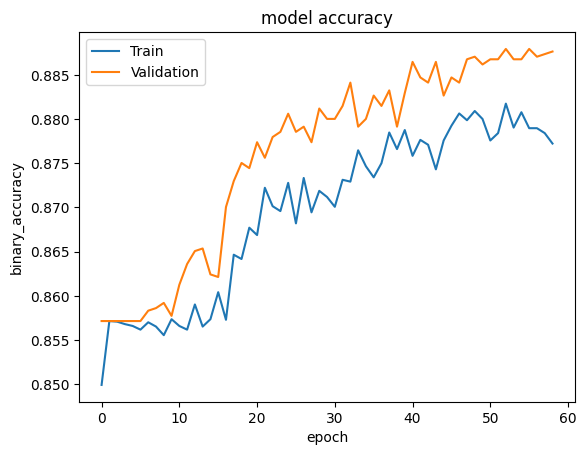

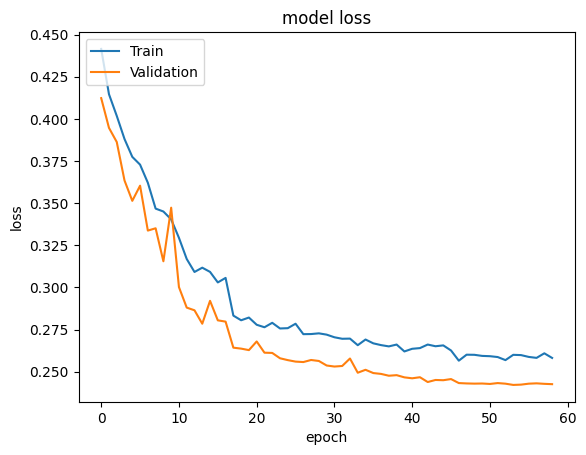

In [ ]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title("model accuracy")
plt.ylabel('binary_accuracy')
plt.xlabel('epoch')
plt.legend(["Train", 'Validation'], loc='upper left')
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel('epoch')
plt.legend(["Train", 'Validation'], loc='upper left')
plt.show()